In [1]:
import os
import json
import torch
import matplotlib.pyplot as plt
from datasets import load_from_disk
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, pipeline, Trainer, TrainingArguments,TrainerCallback

device = "cuda"

d:\intern\phi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the pre-trained tokenizer and model
local_path = "distilbert-NER" #global_path = "dslim/distilbert-NER"

tokenizer = AutoTokenizer.from_pretrained(local_path)
model = AutoModelForTokenClassification.from_pretrained(local_path)

old_classifier = model.classifier  # Save the old classifier(last layer of the model)

model.classifier = torch.nn.Linear(model.config.hidden_size, 11) # creale new linear layer for icrease output number from 9 to 11

torch.nn.init.xavier_uniform_(model.classifier.weight) # generate new weights

with torch.no_grad():
    model.classifier.weight[:old_classifier.weight.size(0), :] = old_classifier.weight  # Copy old weights
    model.classifier.bias[:old_classifier.bias.size(0)] = old_classifier.bias  # Copy old bias


# changing model metadata to match new one
model.num_labels = 11 

model.config.id2label = {
                        0: 'O', 
                        1: 'B-PER', 
                        2: 'I-PER', 
                        3: 'B-ORG', 
                        4: 'I-ORG', 
                        5: 'B-LOC', 
                        6: 'I-LOC', 
                        7: 'B-MISC', 
                        8: 'I-MISC', 
                        9: 'B-MOU', 
                        10: 'I-MOU'
                        }

dataset = load_from_disk("./ner_dataset")


In [86]:

def tokenize_and_align_labels(examples): # prepare data for training
    tokenized_inputs = tokenizer(examples["tokens"], padding=False, truncation=True, is_split_into_words=True) #tokenize the words

    labels = []

    for i, label in enumerate(examples["ner_tags"]): # labeling tokens
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # take word ids for sentance
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore the special tokens in the start and end of sentance
            else:  # Add label for tokens
                label_ids.append(label[word_idx])
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

# Create data collator for padding inputs
data_collator = DataCollatorForTokenClassification(tokenizer)

In [4]:
#data collector for loss plot
metrics_per_epoch = []

class SaveMetricsCallback(TrainerCallback): 
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            # Append current metrics to the list
            metrics_per_epoch.append(metrics)
            
            # Save metrics to a file at each epoch
            with open(os.path.join(args.output_dir, "metrics.json"), "w") as f:
                json.dump(metrics_per_epoch, f, indent=4)

In [5]:
# Create data collator for padding inputs
data_collator = DataCollatorForTokenClassification(tokenizer)

# Set training arguments
training_args = TrainingArguments(
    output_dir="./ner_model_finetuned",  # Output directory
    evaluation_strategy="epoch",         # Evaluate every epoch
    learning_rate=2e-5,                  # Learning rate
    per_device_train_batch_size=200,      # Batch size
    per_device_eval_batch_size=200,       # Batch size for evaluation
    num_train_epochs=25 ,                  # Number of epochs
    weight_decay=0.01,                   # Strength of weight decay
    load_best_model_at_end=True,
    save_strategy='epoch',
)
train_size = (int(len(tokenized_datasets)*0.8))
test_size = len(tokenized_datasets)- train_size
train_set,eval_set = random_split(tokenized_datasets,[train_size,test_size])
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=eval_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[SaveMetricsCallback]
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./finetuned_distilbert_ner")
tokenizer.save_pretrained("./finetuned_distilbert_ner")

d:\intern\phi\.venv\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                              
  4%|▍         | 1/25 [00:00<00:11,  2.11it/s]

{'eval_loss': 0.9968677163124084, 'eval_runtime': 0.021, 'eval_samples_per_second': 2093.322, 'eval_steps_per_second': 47.576, 'epoch': 1.0}


                                              
  8%|▊         | 2/25 [00:01<00:16,  1.38it/s]

{'eval_loss': 0.7652942538261414, 'eval_runtime': 0.019, 'eval_samples_per_second': 2313.693, 'eval_steps_per_second': 52.584, 'epoch': 2.0}


                                              
 12%|█▏        | 3/25 [00:02<00:17,  1.27it/s]

{'eval_loss': 0.6104240417480469, 'eval_runtime': 0.02, 'eval_samples_per_second': 2197.932, 'eval_steps_per_second': 49.953, 'epoch': 3.0}


                                              
 16%|█▌        | 4/25 [00:03<00:16,  1.24it/s]

{'eval_loss': 0.5060350894927979, 'eval_runtime': 0.02, 'eval_samples_per_second': 2197.985, 'eval_steps_per_second': 49.954, 'epoch': 4.0}


                                              
 20%|██        | 5/25 [00:03<00:16,  1.21it/s]

{'eval_loss': 0.4368992745876312, 'eval_runtime': 0.018, 'eval_samples_per_second': 2442.195, 'eval_steps_per_second': 55.504, 'epoch': 5.0}


                                              
 24%|██▍       | 6/25 [00:04<00:15,  1.21it/s]

{'eval_loss': 0.3907025456428528, 'eval_runtime': 0.02, 'eval_samples_per_second': 2198.011, 'eval_steps_per_second': 49.955, 'epoch': 6.0}


                                              
 28%|██▊       | 7/25 [00:05<00:15,  1.19it/s]

{'eval_loss': 0.35652896761894226, 'eval_runtime': 0.02, 'eval_samples_per_second': 2198.011, 'eval_steps_per_second': 49.955, 'epoch': 7.0}


                                              
 32%|███▏      | 8/25 [00:06<00:15,  1.09it/s]

{'eval_loss': 0.3280700743198395, 'eval_runtime': 0.047, 'eval_samples_per_second': 935.318, 'eval_steps_per_second': 21.257, 'epoch': 8.0}


                                              
 36%|███▌      | 9/25 [00:07<00:15,  1.01it/s]

{'eval_loss': 0.30347180366516113, 'eval_runtime': 0.047, 'eval_samples_per_second': 935.322, 'eval_steps_per_second': 21.257, 'epoch': 9.0}


                                               
 40%|████      | 10/25 [00:09<00:15,  1.03s/it]

{'eval_loss': 0.2824462950229645, 'eval_runtime': 0.048, 'eval_samples_per_second': 915.837, 'eval_steps_per_second': 20.814, 'epoch': 10.0}


                                               
 44%|████▍     | 11/25 [00:10<00:14,  1.07s/it]

{'eval_loss': 0.26523593068122864, 'eval_runtime': 0.05, 'eval_samples_per_second': 879.2, 'eval_steps_per_second': 19.982, 'epoch': 11.0}


                                               
 48%|████▊     | 12/25 [00:11<00:14,  1.10s/it]

{'eval_loss': 0.25147637724876404, 'eval_runtime': 0.0495, 'eval_samples_per_second': 889.159, 'eval_steps_per_second': 20.208, 'epoch': 12.0}


                                               
 52%|█████▏    | 13/25 [00:12<00:13,  1.11s/it]

{'eval_loss': 0.2404833734035492, 'eval_runtime': 0.041, 'eval_samples_per_second': 1072.201, 'eval_steps_per_second': 24.368, 'epoch': 13.0}


                                               
 56%|█████▌    | 14/25 [00:13<00:12,  1.11s/it]

{'eval_loss': 0.2313644289970398, 'eval_runtime': 0.047, 'eval_samples_per_second': 935.322, 'eval_steps_per_second': 21.257, 'epoch': 14.0}


                                               
 60%|██████    | 15/25 [00:14<00:11,  1.11s/it]

{'eval_loss': 0.2237759679555893, 'eval_runtime': 0.049, 'eval_samples_per_second': 897.147, 'eval_steps_per_second': 20.39, 'epoch': 15.0}


                                               
 64%|██████▍   | 16/25 [00:15<00:10,  1.12s/it]

{'eval_loss': 0.2177814543247223, 'eval_runtime': 0.048, 'eval_samples_per_second': 915.841, 'eval_steps_per_second': 20.815, 'epoch': 16.0}


                                               
 68%|██████▊   | 17/25 [00:16<00:08,  1.12s/it]

{'eval_loss': 0.2132616490125656, 'eval_runtime': 0.046, 'eval_samples_per_second': 955.66, 'eval_steps_per_second': 21.72, 'epoch': 17.0}


                                               
 72%|███████▏  | 18/25 [00:18<00:07,  1.13s/it]

{'eval_loss': 0.20988598465919495, 'eval_runtime': 0.049, 'eval_samples_per_second': 897.142, 'eval_steps_per_second': 20.39, 'epoch': 18.0}


                                               
 76%|███████▌  | 19/25 [00:19<00:06,  1.15s/it]

{'eval_loss': 0.2075701355934143, 'eval_runtime': 0.045, 'eval_samples_per_second': 976.891, 'eval_steps_per_second': 22.202, 'epoch': 19.0}


                                               
 80%|████████  | 20/25 [00:20<00:05,  1.16s/it]

{'eval_loss': 0.20600929856300354, 'eval_runtime': 0.047, 'eval_samples_per_second': 935.318, 'eval_steps_per_second': 21.257, 'epoch': 20.0}


                                               
 84%|████████▍ | 21/25 [00:21<00:04,  1.15s/it]

{'eval_loss': 0.2049667239189148, 'eval_runtime': 0.047, 'eval_samples_per_second': 935.318, 'eval_steps_per_second': 21.257, 'epoch': 21.0}


                                               
 88%|████████▊ | 22/25 [00:22<00:03,  1.14s/it]

{'eval_loss': 0.20428448915481567, 'eval_runtime': 0.0499, 'eval_samples_per_second': 881.106, 'eval_steps_per_second': 20.025, 'epoch': 22.0}


                                               
 92%|█████████▏| 23/25 [00:23<00:02,  1.13s/it]

{'eval_loss': 0.20385998487472534, 'eval_runtime': 0.051, 'eval_samples_per_second': 861.965, 'eval_steps_per_second': 19.59, 'epoch': 23.0}


                                               
 96%|█████████▌| 24/25 [00:24<00:01,  1.13s/it]

{'eval_loss': 0.20363718271255493, 'eval_runtime': 0.047, 'eval_samples_per_second': 935.318, 'eval_steps_per_second': 21.257, 'epoch': 24.0}


                                               
100%|██████████| 25/25 [00:26<00:00,  1.16s/it]

{'eval_loss': 0.20351558923721313, 'eval_runtime': 0.038, 'eval_samples_per_second': 1156.861, 'eval_steps_per_second': 26.292, 'epoch': 25.0}


100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


{'train_runtime': 27.8291, 'train_samples_per_second': 154.515, 'train_steps_per_second': 0.898, 'train_loss': 0.31497222900390626, 'epoch': 25.0}


('./finetuned_distilbert_ner\\tokenizer_config.json',
 './finetuned_distilbert_ner\\special_tokens_map.json',
 './finetuned_distilbert_ner\\vocab.txt',
 './finetuned_distilbert_ner\\added_tokens.json',
 './finetuned_distilbert_ner\\tokenizer.json')

In [7]:
fine_tuned_path = "finetuned_distilbert_ner"
fine_tuned_model = AutoModelForTokenClassification.from_pretrained(fine_tuned_path)
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(fine_tuned_path)

pipe = pipeline(task = 'ner', model = fine_tuned_model, tokenizer= fine_tuned_tokenizer, device= device)

In [8]:
input = "Nestled between the soaring peaks of the Tatra Mountains, Zdiar's picturesque charm draws visitors from all over"
output = pipe(input)
for word in output:
    print(f"{word['word']} -> {word['entity']}")

Ta -> B-MOU
##tra -> B-MOU
Mountains -> I-MOU
Z -> B-MOU
##dia -> B-MOU
##r -> B-MOU
' -> B-MOU


token number = 2783
sentances number = 216


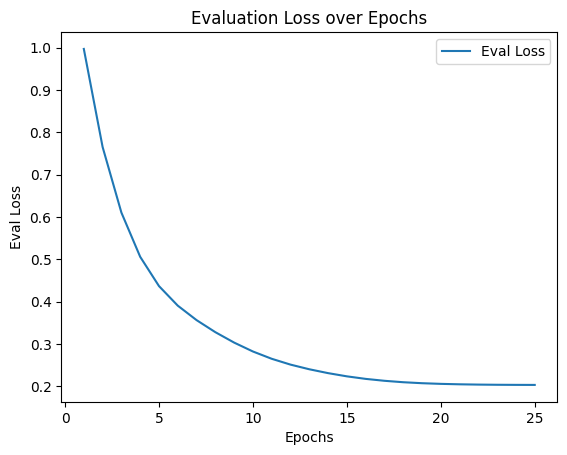

In [6]:
token_number = sum([len(i) for i in tokenized_datasets['tokens']])
sentances = len(tokenized_datasets)
print(f"token number = {token_number}")
print(f"sentances number = {sentances}")

# plot loss curve
with open("./ner_model_finetuned/metrics.json", "r") as f:
    metrics_per_epoch = json.load(f)

# Plot metrics (e.g., evaluation loss)
epochs = range(1, len(metrics_per_epoch) + 1)
eval_losses = [epoch["eval_loss"] for epoch in metrics_per_epoch]

plt.plot(epochs, eval_losses, label="Eval Loss")
plt.xlabel('Epochs')
plt.ylabel('Eval Loss')
plt.title('Evaluation Loss over Epochs')
plt.legend()
plt.show()

In [123]:
# Define the model name or path to the finetuned model
model_name = "finetuned_distilbert_ner"  # Replace with your model path

# Load the pre-trained model and tokenizer for token classification (NER)
model = AutoModelForTokenClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set the model to evaluation mode (disables dropout and other training-specific operations)
model.eval()

# Initialize lists to store accuracy, precision, recall, and F1 score for each evaluation sample
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []

# Loop over the evaluation dataset
for sample in eval_set:
    # Convert the ground truth labels and input features (input_ids, attention_mask) into PyTorch tensors
    y_true = torch.tensor(sample['labels'])
    input_ids = torch.tensor([sample['input_ids']])
    attention_mask = torch.tensor([sample['attention_mask']])

    # Perform inference without computing gradients (for faster evaluation)
    with torch.no_grad():  # Disable gradient calculation since we're only doing evaluation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract the logits (raw model predictions) from the output and squeeze to remove extra dimensions
    logits = outputs.logits.squeeze()

    # Get the predicted class for each token by selecting the index of the maximum logit (most probable class)
    predictions = torch.argmax(logits, dim=1)

    # Calculate evaluation metrics: accuracy, precision, recall, and F1 score
    accuracy = accuracy_score(y_true, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, predictions, average='weighted', zero_division=True)

    # Append each metric to its corresponding list for analysis later
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

In [125]:
print(f"Accytacy= {sum(accuracy_list)/len(accuracy_list)}")
print(f"Precision= {sum(precision_list)/len(precision_list)}")
print(f"Recall= {sum(recall_list)/len(recall_list)}")
print(f"f1_list= {sum(f1_list)/len(f1_list)}")


Accytacy= 0.7906569963289694
Precision= 0.8536029074588288
Recall= 0.7906569963289694
f1_list= 0.7117091315269529
